In [17]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
import csv

In [3]:
data_df = pd.read_csv('../predicting-satisfaction-using-graphs/csv/dataset/avg_satisfaction_raw_0-999.csv', encoding='ISO-8859-1')

In [82]:
list_satisfaction = list(data_df['satisfy_composite'])
list_tag = list(data_df['postIndex'])
list_post = list(data_df['postContent'])
list_comment = list(data_df['commentContent'])

In [5]:
list_content = []
for p, c in zip(list_post, list_comment):
    list_content.append(p+' '+c)

# Doc2Vec

In [6]:
def train_doc2vec(data, tag, model_name, mode):
    tagged_data = [TaggedDocument(words=word_tokenize(term.lower()), tags=[tag[i]]) for i, term in enumerate(data)]
    
    max_epochs = 500
    vec_size = 100
    alpha = 0.025

    model = Doc2Vec(vector_size=vec_size,
                   alpha=alpha,
                   min_alpha=0.00025,
                   min_count=1,
                   dm=1)

    model.build_vocab(tagged_data)
    
    for epoch in range(max_epochs):
        if epoch % 100 == 0:
            print('iteration {0}'.format(epoch))
    
        model.train(tagged_data,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)
    
        model.alpha -= 0.0002
        model.min_alpha = model.alpha
    
    model.save(f"{model_name}")
    
    embeddings = []
    for i in range(1000):
        embeddings.append(list(model.dv[i]))
        
    if mode == "regression":
        return embeddings
    else:
        tsne = TSNE(random_state = 42)
        data_tsne = tsne.fit_transform(embeddings)
    
        x_for_tsne = []
        y_for_tsne = []

        for xy in data_tsne:
            x_for_tsne.append(xy[0])
            y_for_tsne.append(xy[1])
        
        return x_for_tsne, y_for_tsne

In [180]:
def t_sne(x, y, score, xlabel, ylabel, annotate=[]):
    size = list(map(lambda x:x*200, score))
    size = list(map(abs, size))
    minsize = min(size)
    maxsize = max(size)
    

    tsne_df = pd.DataFrame({'x': x, 'y': y, 'color': score, 'size': size})

    fig, ax = plt.subplots()

    # set before set_style
    sns.set(rc={'figure.figsize':(30,25)})
    sns.set_style("white")

    ax = sns.scatterplot(x = 'x', y = 'y', hue="color", size = "size", data=tsne_df, palette='cool', 
                        sizes=(minsize, maxsize), alpha=0.65, edgecolor="black", linewidth=1, legend = False)
    
    if annotate:
        for i in range(len(score)):
            if abs(score[i]) >= 2:
                ax.annotate(f'{round(score[i], 2)}, {annotate[i]}', (x[i], y[i]+0.15), fontsize=14)
    else:
        for i, s in enumerate(score):
            ax.annotate(round(s, 2), (x[i], y[i]+0.15), fontsize=10)

    ax.set(xlabel=None, ylabel=None)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, 
                            norm=plt.Normalize(vmin=min(score), vmax=max(score)))

    cbar = fig.colorbar(sm)

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


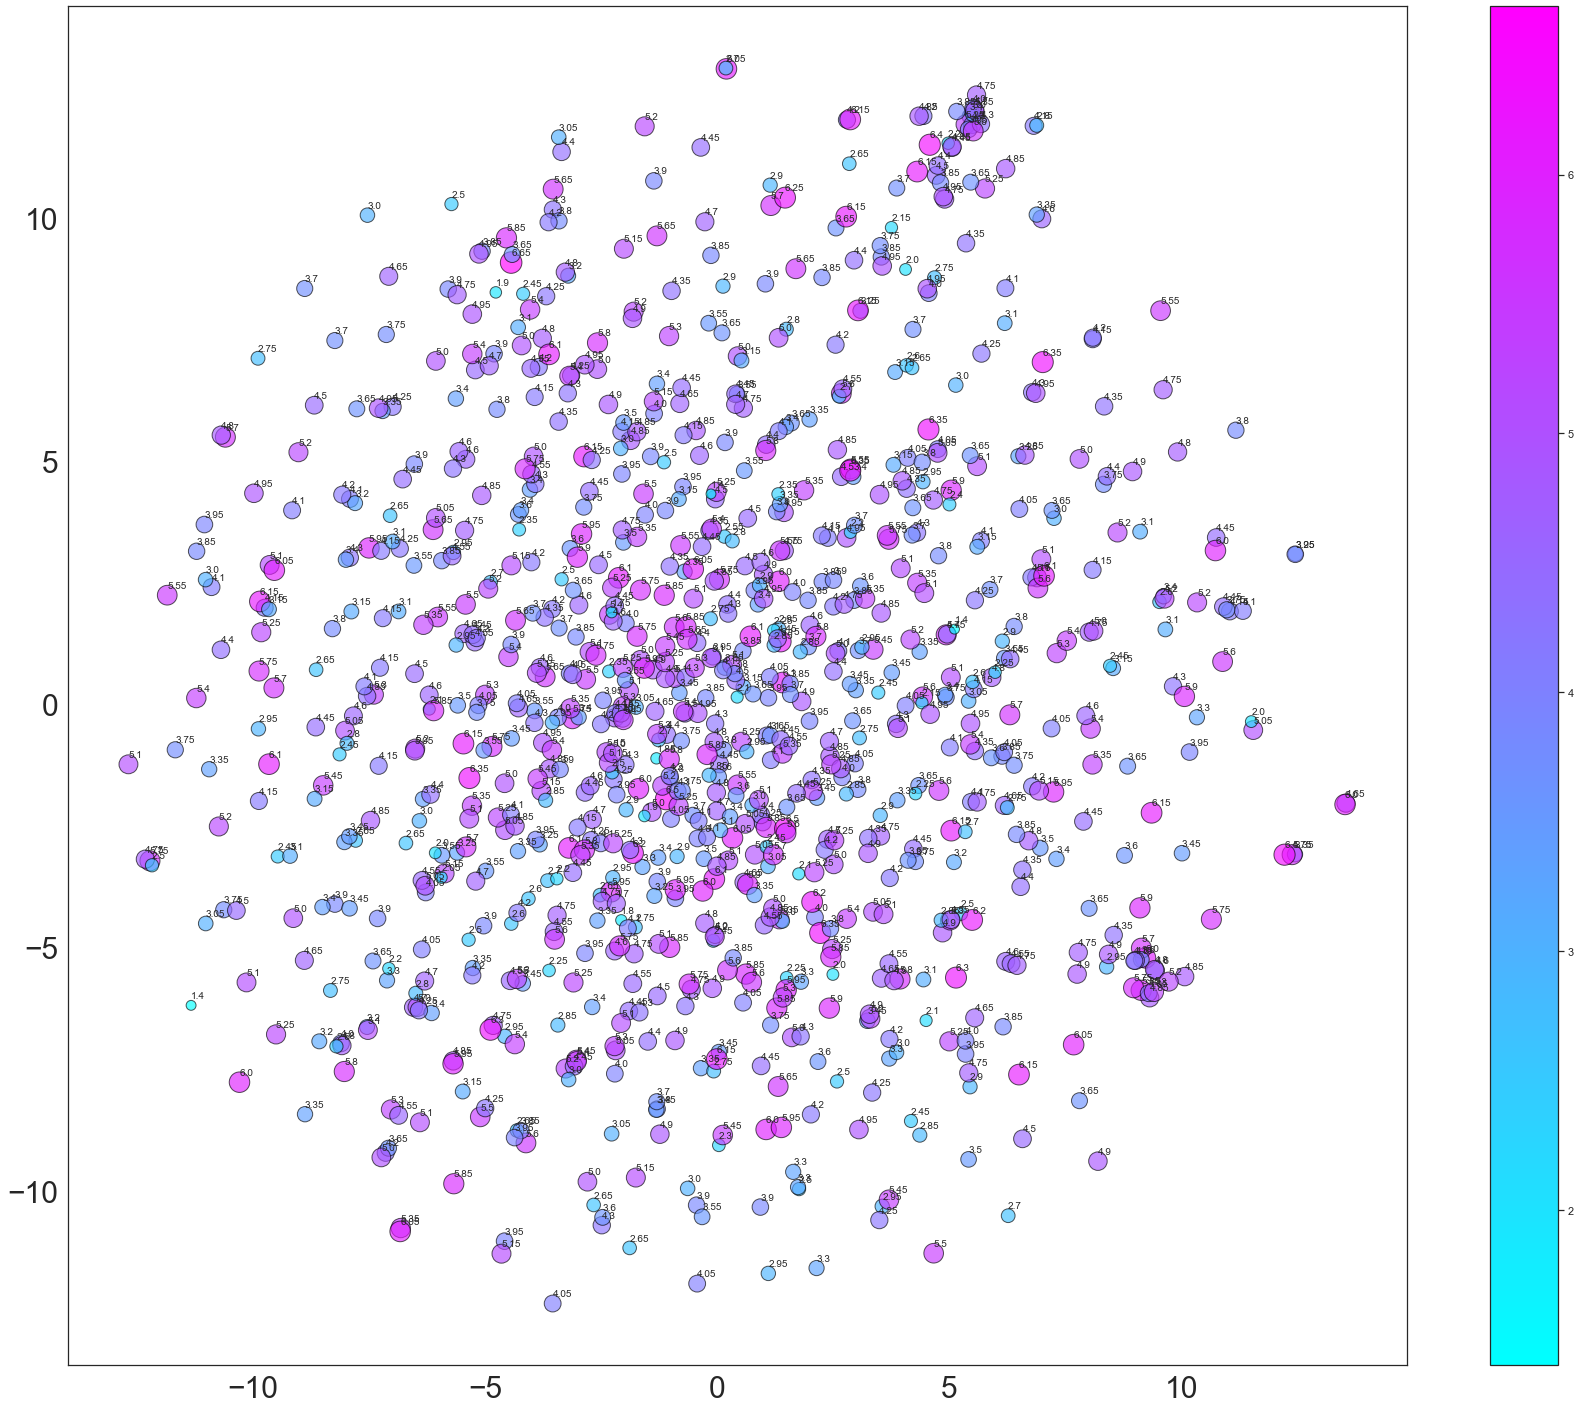

In [91]:
x_for_tsne, y_for_tsne = train_doc2vec(list_content, list_tag, "post_comment.model", "tsne")
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


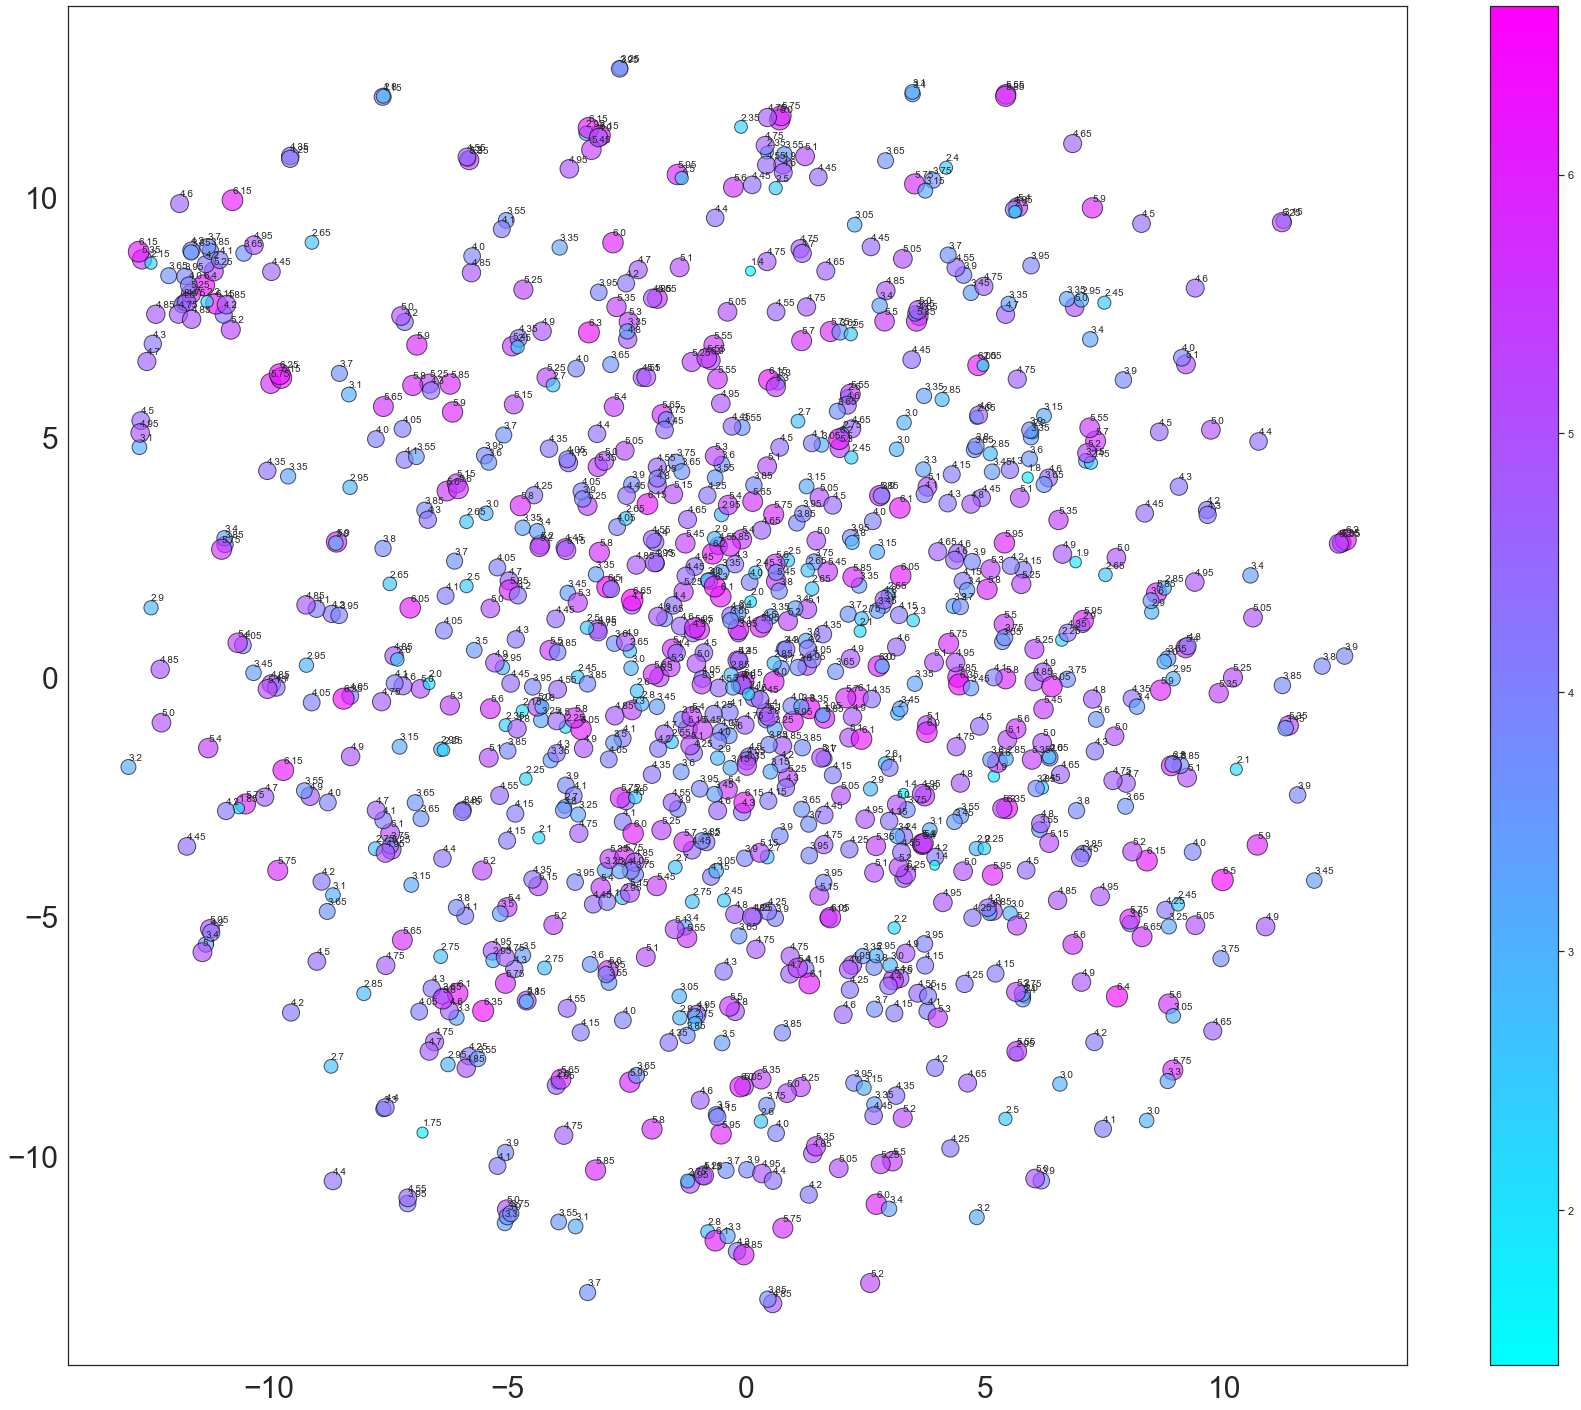

In [92]:
x_for_tsne, y_for_tsne = train_doc2vec(list_post, list_tag, "post.model", "tsne")
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


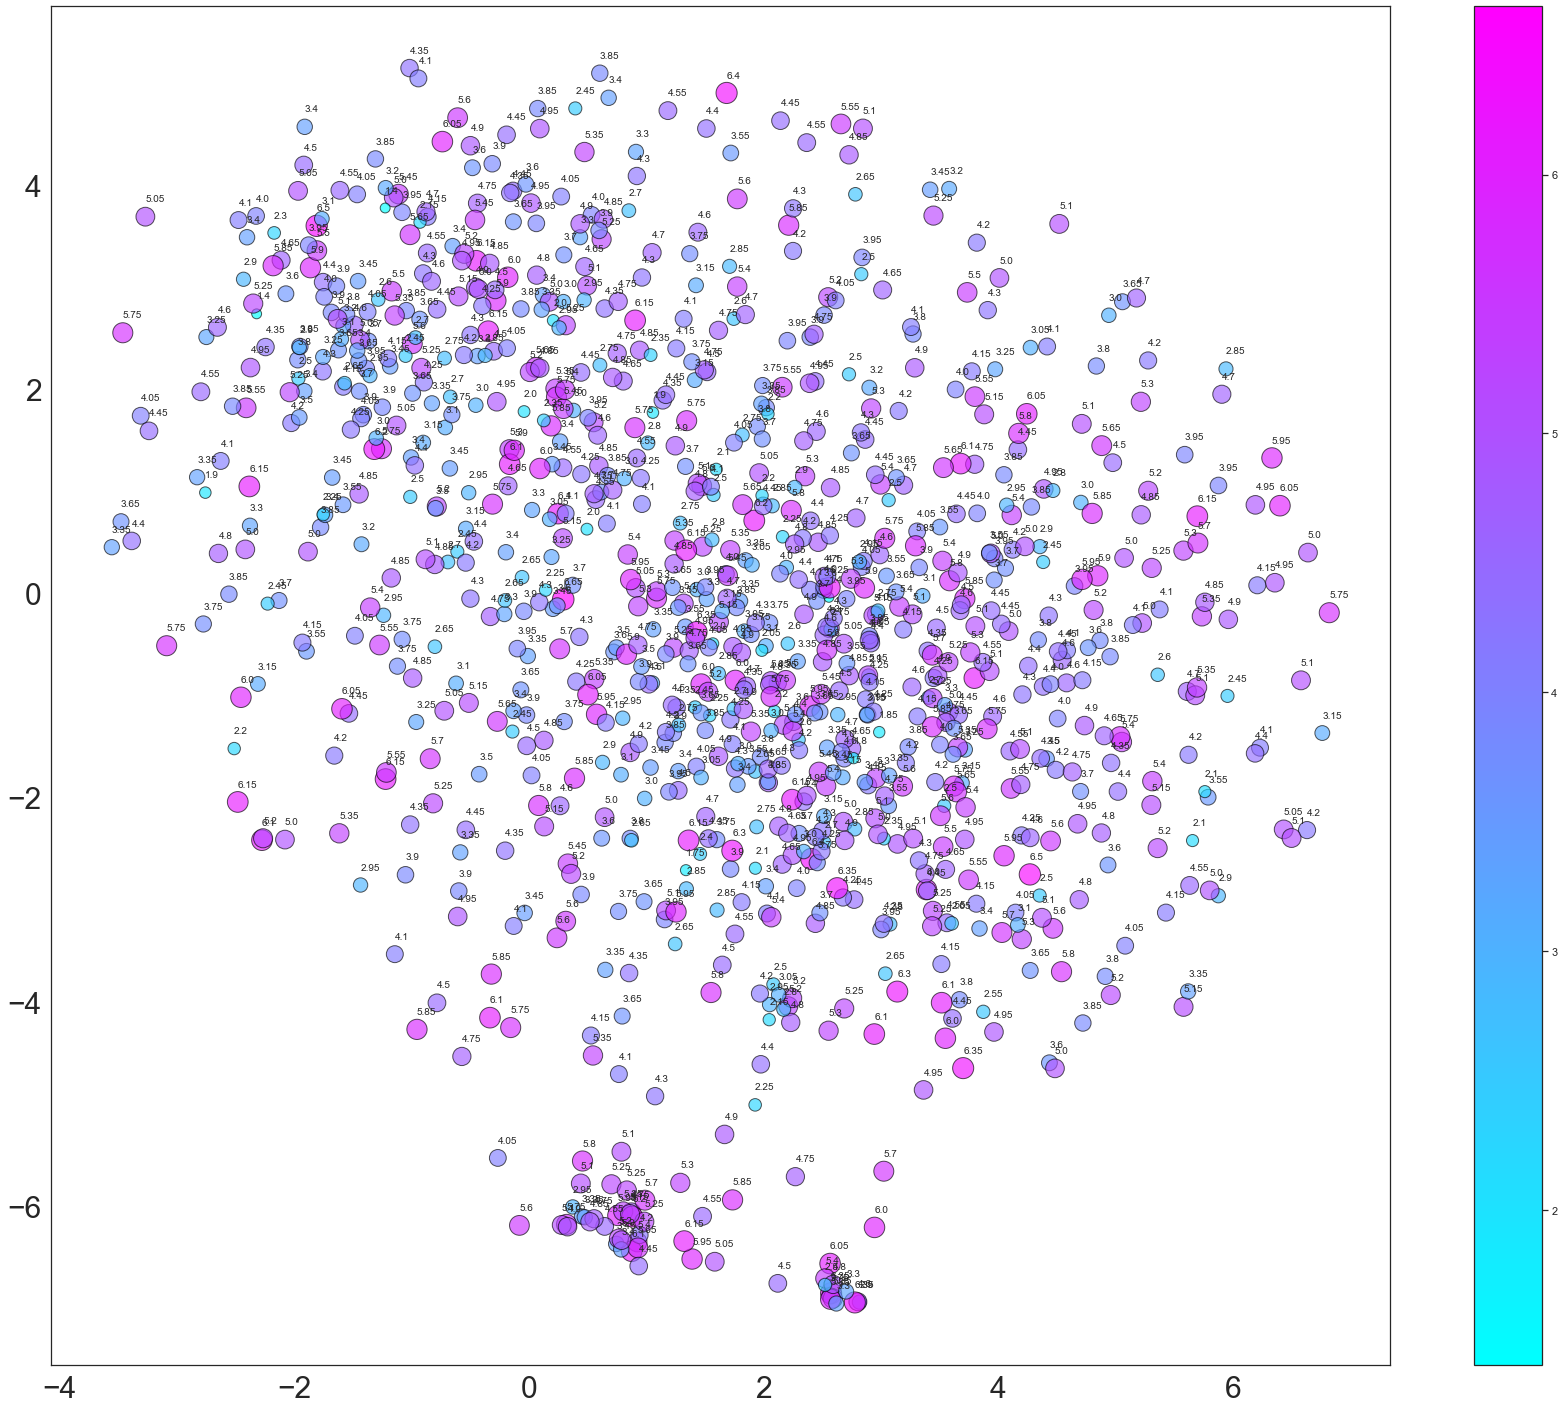

In [93]:
x_for_tsne, y_for_tsne = train_doc2vec(list_comment, list_tag, "comment.model", "tsne")
t_sne(x_for_tsne, y_for_tsne, list_satisfaction, 'x', 'y')

In [7]:
embeddings = train_doc2vec(list_content, list_tag, "post_comment.model", "regression")

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400


In [10]:
print(len(embeddings))

1000


In [84]:
data = []
for i in range(len(embeddings)):
    data.append([embeddings[i], list_satisfaction[i], list_tag[i]])
data = pd.DataFrame(data, columns=['x', 'y', 'i'])

In [129]:
data_list = []
for i in range(len(embeddings)):
    data_list.append([embeddings[i], list_satisfaction[i], list_tag[i]])

In [106]:
# train-test split
test_size = 0.2
train, test = train_test_split(data, test_size=0.2)

x_train = torch.Tensor([x for x in list(train.x)])
y_train = torch.Tensor([[y] for y in list(train.y)])
i_train = torch.Tensor([[i] for i in list(train.i)])

x_test = torch.Tensor([x for x in list(test.x)])
y_test = torch.Tensor([[y] for y in list(test.y)])
i_test = torch.Tensor([[i] for i in list(test.i)])


train_data = TensorDataset(x_train, y_train, i_train)
test_data = TensorDataset(x_test, y_test, i_test)

batch_size = 5
train_dl = DataLoader(train_data, batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size, shuffle=False)

In [27]:
def generate_xy_for_tsne(embeddings):
    tsne = TSNE(random_state = 42)
    data_tsne = tsne.fit_transform(embeddings)
    
    x_for_tsne = []
    y_for_tsne = []

    for xy in data_tsne:
        x_for_tsne.append(xy[0])
        y_for_tsne.append(xy[1])
        
    return x_for_tsne, y_for_tsne

<generator object <genexpr> at 0x7f26383616d0>


In [107]:
test_embeddings = [x for x in list(test.x)]
test_score = [y for y in list(test.y)]
x_test_for_tsne, y_test_for_tsne = generate_xy_for_tsne(test_embeddings)

In [111]:
t_sne(x_for_tsne, y_for_tsne, test_score, 'x', 'y')

ValueError: All arrays must be of the same length

In [108]:
train_embeddings = [x for x in list(train.x)]
train_score = [y for y in list(train.y)]
x_train_for_tsne, y_train_for_tsne = generate_xy_for_tsne(train_embeddings)

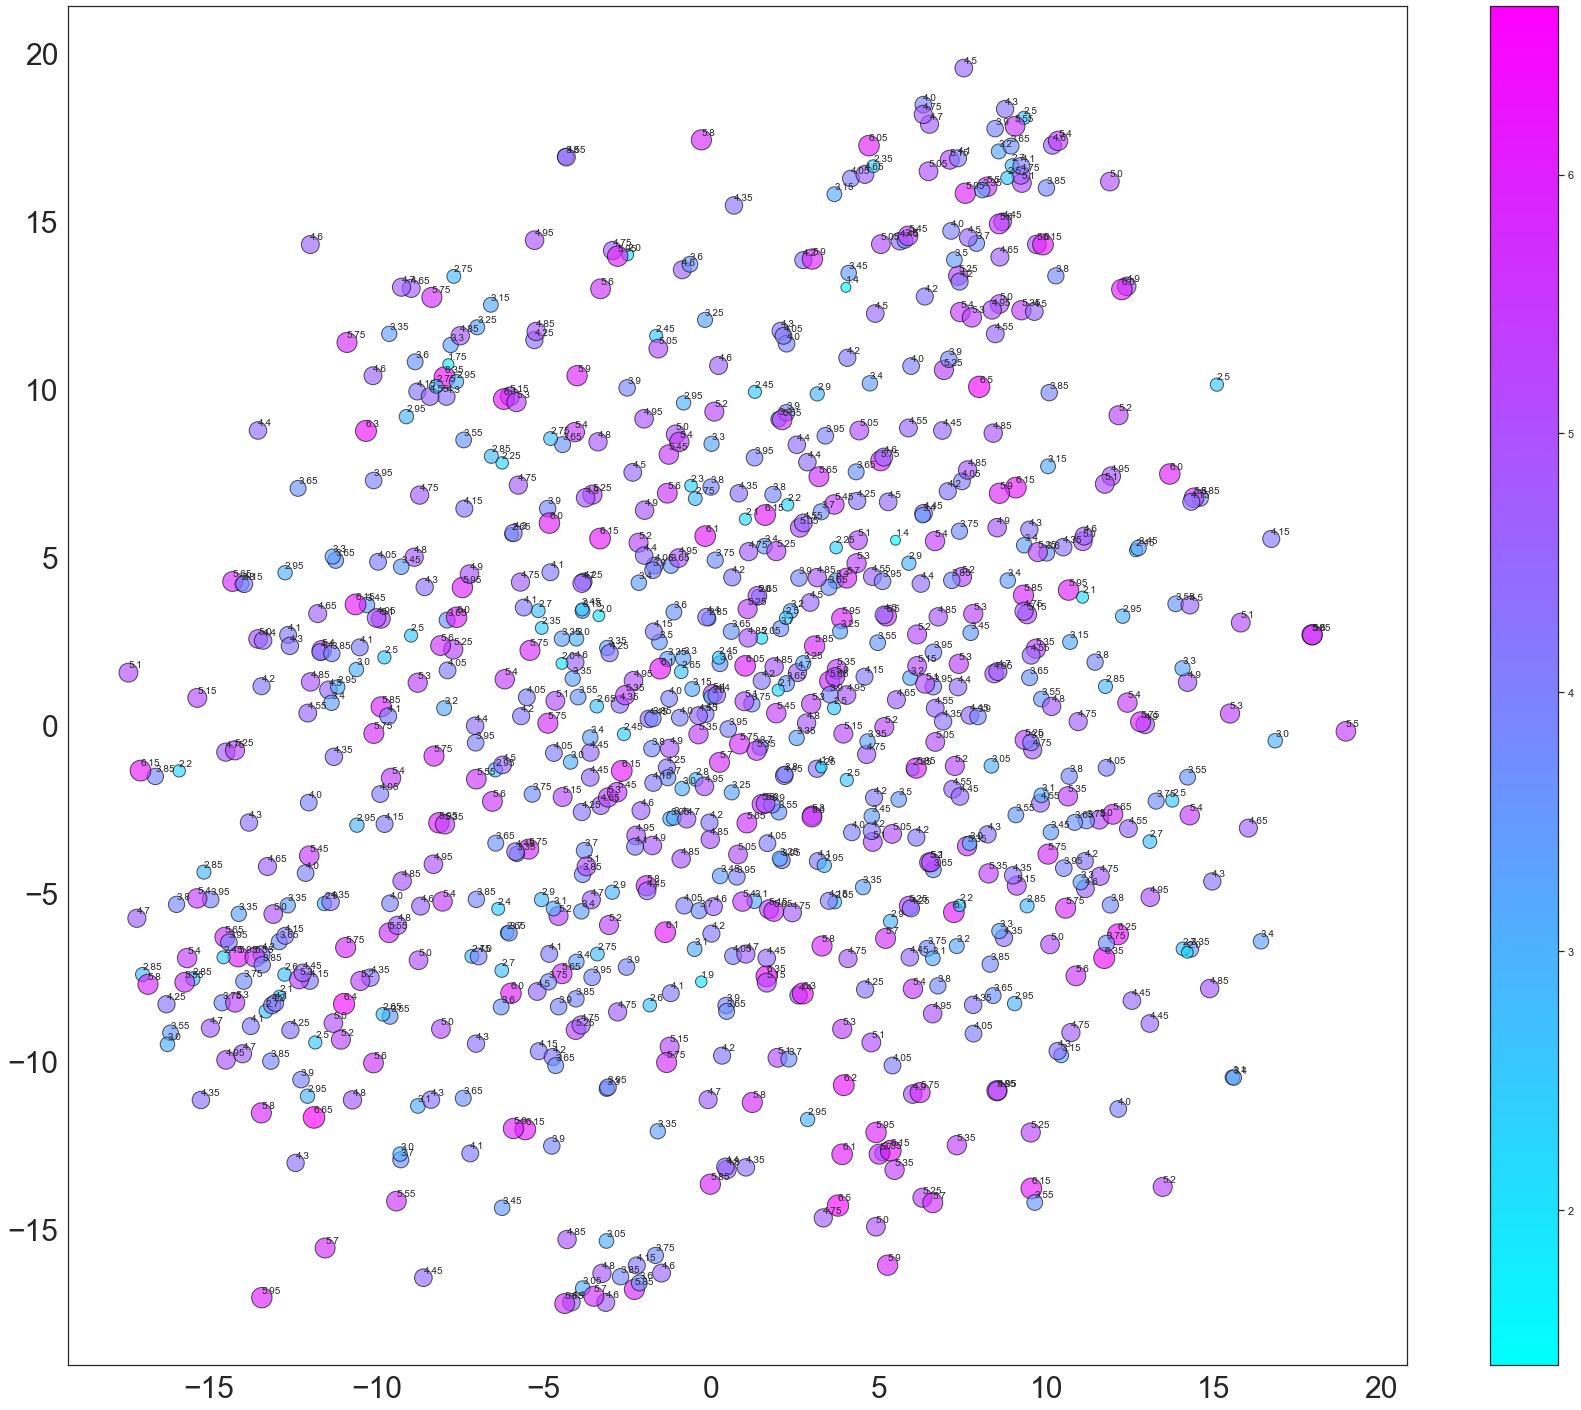

In [40]:
t_sne(x_for_tsne, y_for_tsne, train_score, 'x', 'y')

In [79]:
def t_sne_for_train_test(x_train, y_train, x_test, y_test, train_score, test_score, xlabel, ylabel):
    score = train_score + test_score
    print(len(score))
    size = list(map(lambda x:x*70, score))
    
    train_size = size[0:800]
    test_size = size[800:1000]
    
    minsize = min(size)
    maxsize = max(size)

    train_tsne_df = pd.DataFrame({'x': x_train, 'y': y_train, 'color': 'red', 'size': train_size})
    test_tsne_df = pd.DataFrame({'x': x_test, 'y': y_test, 'color': 'blue', 'size': test_size})
    
    tsne_df = pd.concat([train_tsne_df, test_tsne_df])
    print(len(tsne_df))

    fig, ax = plt.subplots()

    # set before set_style
    sns.set(rc={'figure.figsize':(30,25)})
    sns.set_style("white")

    ax = sns.scatterplot(x = 'x', y = 'y', hue="color", size = "size", data=tsne_df, palette='cool', 
                        sizes=(minsize, maxsize), alpha=0.65, edgecolor="black", linewidth=1, legend = False)
    
    
    # for i, s in enumerate(score):
    #     ax.annotate(round(s, 2), (tsne_df.x[i], tsne_df.y[i]+0.15), fontsize=10)
    

    ax.set(xlabel=None, ylabel=None)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, 
                            norm=plt.Normalize(vmin=min(score), vmax=max(score)))

    cbar = fig.colorbar(sm)

1000
1000


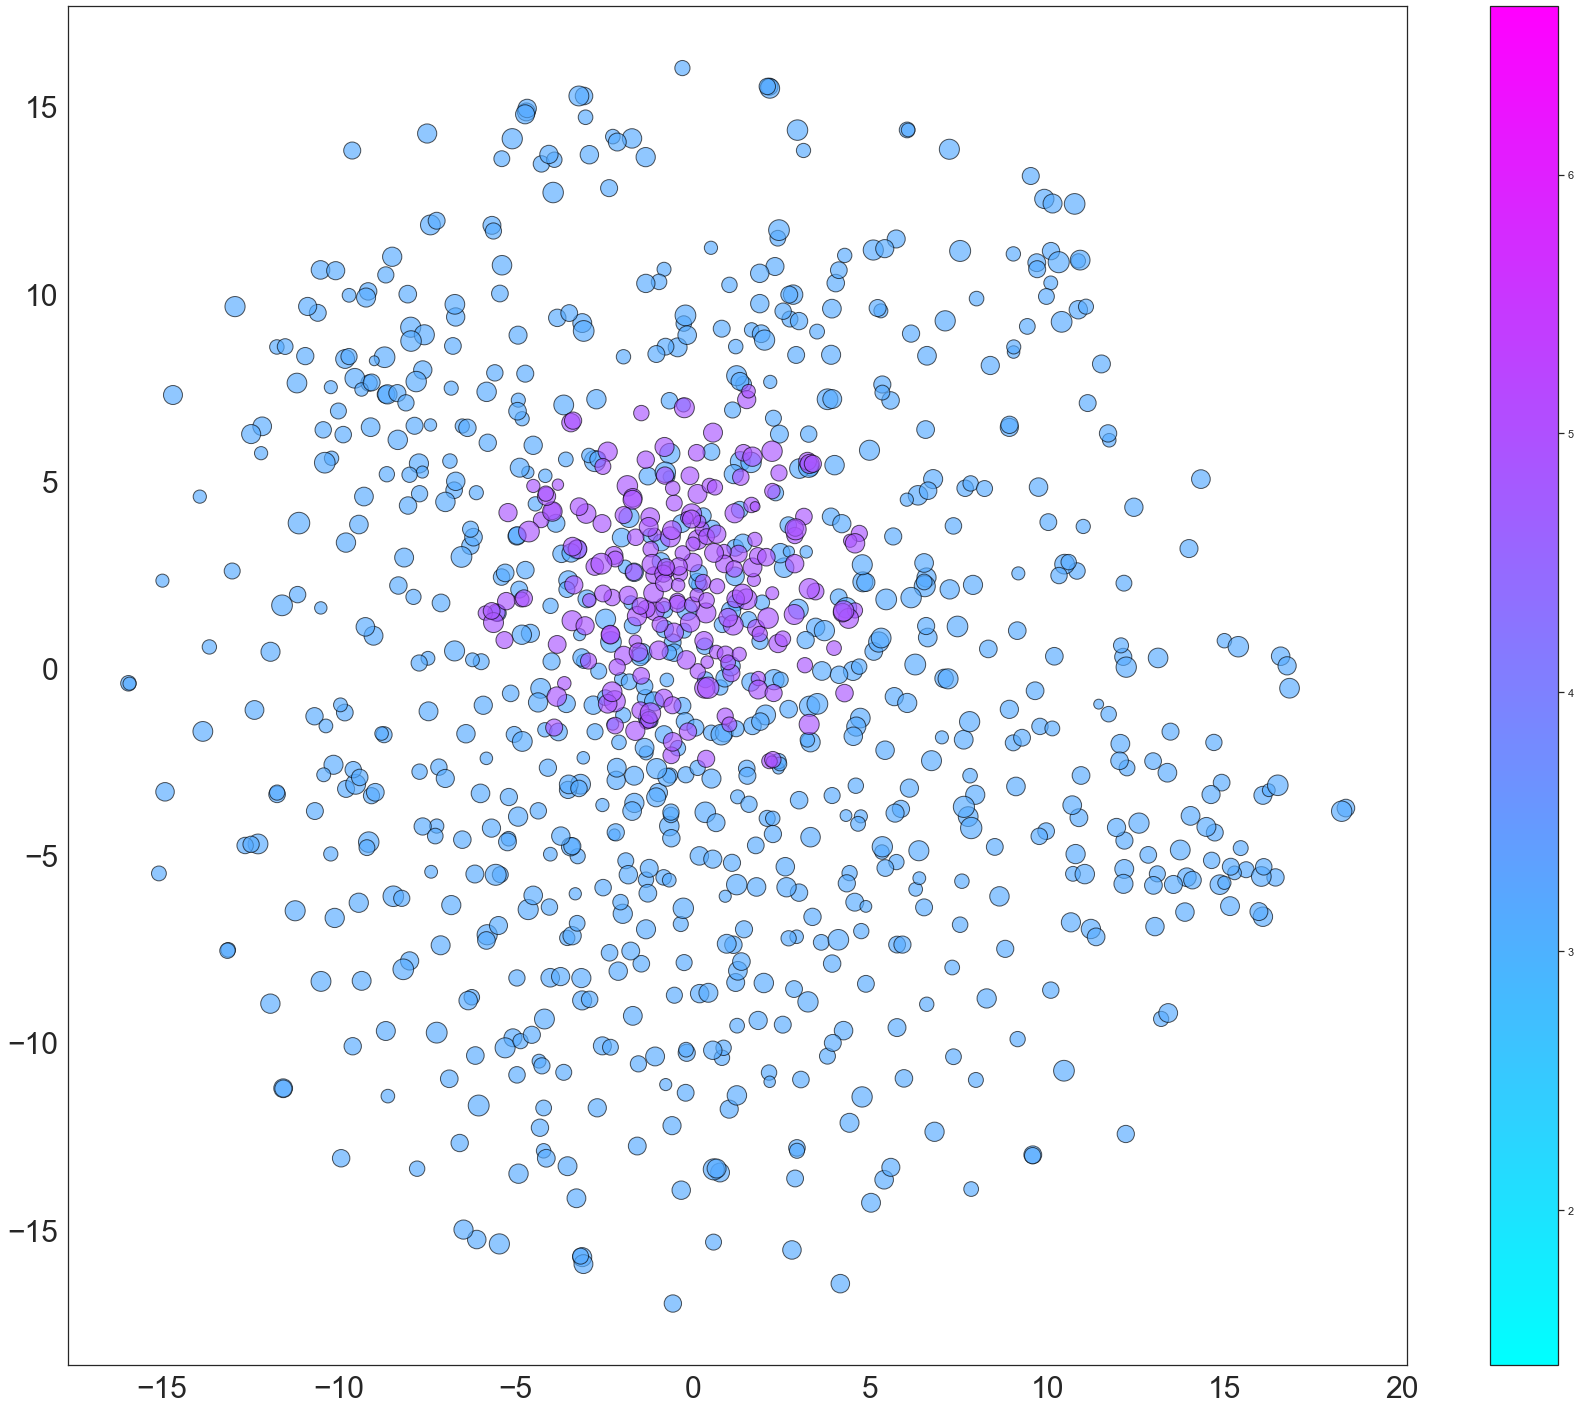

In [109]:
t_sne_for_train_test(x_train_for_tsne, y_train_for_tsne, x_test_for_tsne, y_test_for_tsne, train_score, test_score, 'x', 'y')

In [ ]:
def t_sne_train_test(x, y, score, xlabel, ylabel):
    size = list(map(lambda x:x*70, score))
    
    minsize = min(size)
    maxsize = max(size)

    tsne_df = pd.DataFrame({'x': x, 'y': y, 'color': score, 'size': size})

    fig, ax = plt.subplots()

    # set before set_style
    sns.set(rc={'figure.figsize':(30,25)})
    sns.set_style("white")

    ax = sns.scatterplot(x = 'x', y = 'y', hue="color", size = "size", data=tsne_df, palette='cool', 
                        sizes=(minsize, maxsize), alpha=0.65, edgecolor="black", linewidth=1, legend = False)
    
    for i, s in enumerate(score):
        ax.annotate(round(s, 2), (x[i], y[i]+0.15), fontsize=10)

    ax.set(xlabel=None, ylabel=None)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, 
                            norm=plt.Normalize(vmin=min(score), vmax=max(score)))

    cbar = fig.colorbar(sm)

In [114]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        logit = self.fc2(self.fc1(x))
        output = self.fc1(x)
        output = self.dropout(output)
        output = self.relu(output)
        logit = self.fc2(output)

        return logit


def regression(num_epochs, model, loss_fun, optimizer, train_dl, test_dl):
    training_result = []

    for epoch in range(1, num_epochs+1):
        avg_loss = 0
        for xb, yb, ib in train_dl:
            pred = model(xb)
            loss = loss_fun(pred, yb)
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, avg_loss / len(train_dl)))

        pred_df, true_df, val_loss, r2score = evaluate(test_dl)

        training_result.append([epoch, avg_loss / len(train_dl), val_loss, r2score])

        pred_df.to_csv(f'../predicting-satisfaction-using-graphs/csv/doc2vec/pred/epoch_{epoch}_predicted_vals.csv')
        true_df.to_csv(f'../predicting-satisfaction-using-graphs/csv/doc2vec/true/epoch_{epoch}_true_vals.csv')

    fields = ['epoch', 'training_loss', 'validation_loss', 'r^2_score']

    with open(
            f'../predicting-satisfaction-using-graphs/csv/doc2vec/training_result.csv',
            'w', newline='') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)

        write.writerow(fields)
        write.writerows(training_result)


def evaluate(test_dl):
    avg_loss = 0
    predictions = []
    true_vals = []
    indexes = []
    for xb, yb, ib in test_dl:
        pred = model(xb)
        loss = loss_fun(pred, yb)
        avg_loss += loss.item()

        pred = pred.detach().cpu().numpy()
        yb = yb.detach().cpu().numpy()
        ib = ib.detach().cpu().numpy()

        predictions.append(pred)
        true_vals.append(yb)
        indexes.append(ib)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    indexes = np.concatenate(indexes, axis=0)

    pred_df = pd.DataFrame(torch.Tensor(predictions).tolist())
    true_df = pd.DataFrame(torch.Tensor(true_vals).tolist())
    index_df = pd.DataFrame(torch.Tensor(indexes).tolist())
    
    pred_df = pd.concat([pred_df, index_df], axis=1)
    true_df = pd.concat([true_df, index_df], axis=1)

    # print('validation loss: {:.4f}, R^2 score: {:.4f}'.format((avg_loss / len(test_dl)), r2_score(true_vals, predictions)))
    return pred_df, true_df, avg_loss / len(test_dl), r2_score(true_vals, predictions)

In [116]:
model = Regressor()
loss_fun = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

num_epochs = 7000
regression(num_epochs, model, loss_fun, optimizer, train_dl, test_dl)

Epoch [10/7000], Loss: 2.7222
Epoch [20/7000], Loss: 2.4883
Epoch [30/7000], Loss: 2.2661
Epoch [40/7000], Loss: 1.9209
Epoch [50/7000], Loss: 1.8147
Epoch [60/7000], Loss: 1.7567
Epoch [70/7000], Loss: 1.6777
Epoch [80/7000], Loss: 1.6701
Epoch [90/7000], Loss: 1.5514
Epoch [100/7000], Loss: 1.4929
Epoch [110/7000], Loss: 1.3944
Epoch [120/7000], Loss: 1.4324
Epoch [130/7000], Loss: 1.4300
Epoch [140/7000], Loss: 1.3882
Epoch [150/7000], Loss: 1.3301
Epoch [160/7000], Loss: 1.3334
Epoch [170/7000], Loss: 1.3431
Epoch [180/7000], Loss: 1.2816
Epoch [190/7000], Loss: 1.2509
Epoch [200/7000], Loss: 1.2418
Epoch [210/7000], Loss: 1.2197
Epoch [220/7000], Loss: 1.2736
Epoch [230/7000], Loss: 1.2016
Epoch [240/7000], Loss: 1.2138
Epoch [250/7000], Loss: 1.2169
Epoch [260/7000], Loss: 1.1966
Epoch [270/7000], Loss: 1.1524
Epoch [280/7000], Loss: 1.1392
Epoch [290/7000], Loss: 1.1325
Epoch [300/7000], Loss: 1.1212
Epoch [310/7000], Loss: 1.0563
Epoch [320/7000], Loss: 1.0798
Epoch [330/7000],

Epoch [2610/7000], Loss: 0.3999
Epoch [2620/7000], Loss: 0.3633
Epoch [2630/7000], Loss: 0.3712
Epoch [2640/7000], Loss: 0.3659
Epoch [2650/7000], Loss: 0.3562
Epoch [2660/7000], Loss: 0.3615
Epoch [2670/7000], Loss: 0.3714
Epoch [2680/7000], Loss: 0.4228
Epoch [2690/7000], Loss: 0.3833
Epoch [2700/7000], Loss: 0.3941
Epoch [2710/7000], Loss: 0.3575
Epoch [2720/7000], Loss: 0.3856
Epoch [2730/7000], Loss: 0.3947
Epoch [2740/7000], Loss: 0.3613
Epoch [2750/7000], Loss: 0.3850
Epoch [2760/7000], Loss: 0.3494
Epoch [2770/7000], Loss: 0.3670
Epoch [2780/7000], Loss: 0.3459
Epoch [2790/7000], Loss: 0.3507
Epoch [2800/7000], Loss: 0.3598
Epoch [2810/7000], Loss: 0.3568
Epoch [2820/7000], Loss: 0.3837
Epoch [2830/7000], Loss: 0.3575
Epoch [2840/7000], Loss: 0.3543
Epoch [2850/7000], Loss: 0.3729
Epoch [2860/7000], Loss: 0.3595
Epoch [2870/7000], Loss: 0.3879
Epoch [2880/7000], Loss: 0.3586
Epoch [2890/7000], Loss: 0.3569
Epoch [2900/7000], Loss: 0.3197
Epoch [2910/7000], Loss: 0.3386
Epoch [2

Epoch [5180/7000], Loss: 0.2519
Epoch [5190/7000], Loss: 0.2447
Epoch [5200/7000], Loss: 0.2377
Epoch [5210/7000], Loss: 0.2521
Epoch [5220/7000], Loss: 0.2580
Epoch [5230/7000], Loss: 0.2629
Epoch [5240/7000], Loss: 0.2548
Epoch [5250/7000], Loss: 0.2519
Epoch [5260/7000], Loss: 0.2370
Epoch [5270/7000], Loss: 0.2309
Epoch [5280/7000], Loss: 0.2249
Epoch [5290/7000], Loss: 0.2254
Epoch [5300/7000], Loss: 0.2151
Epoch [5310/7000], Loss: 0.2497
Epoch [5320/7000], Loss: 0.2479
Epoch [5330/7000], Loss: 0.2394
Epoch [5340/7000], Loss: 0.2367
Epoch [5350/7000], Loss: 0.2577
Epoch [5360/7000], Loss: 0.2488
Epoch [5370/7000], Loss: 0.2421
Epoch [5380/7000], Loss: 0.2225
Epoch [5390/7000], Loss: 0.2270
Epoch [5400/7000], Loss: 0.2529
Epoch [5410/7000], Loss: 0.2269
Epoch [5420/7000], Loss: 0.2671
Epoch [5430/7000], Loss: 0.2274
Epoch [5440/7000], Loss: 0.2164
Epoch [5450/7000], Loss: 0.2530
Epoch [5460/7000], Loss: 0.2245
Epoch [5470/7000], Loss: 0.2463
Epoch [5480/7000], Loss: 0.2548
Epoch [5

In [120]:
prediction_df = pd.read_csv('../predicting-satisfaction-using-graphs/csv/doc2vec/pred/epoch_872_predicted_vals.csv', encoding='ISO-8859-1')
true_vals_df = pd.read_csv('../predicting-satisfaction-using-graphs/csv/doc2vec/true/epoch_872_true_vals.csv', encoding='ISO-8859-1')


In [135]:
list_prediction = list(prediction_df['0'])
list_true_vals = list(true_vals_df['0'])
list_index = list(true_vals_df['0.1'])

4.252446174621582 5.400000095367432
3.677512645721436 3.799999952316284
3.479670763015747 2.900000095367432
4.307639598846436 4.550000190734863
3.657772064208984 4.300000190734863
4.146743774414063 3.3499999046325684
4.718724250793457 4.849999904632568
4.1453166007995605 3.700000047683716
3.6248679161071777 3.75
4.145415782928467 4.550000190734863
4.69227933883667 3.950000047683716
4.169716358184815 3.900000095367432
4.10063362121582 5.0
3.734386682510376 3.950000047683716
5.577762126922607 4.150000095367432
3.440880537033081 6.099999904632568
4.211675643920898 6.400000095367432
3.993812799453736 5.449999809265137
4.620521068572998 2.5999999046325684
4.653730392456055 2.400000095367432
3.860064268112183 5.199999809265137
3.953261137008667 5.099999904632568
3.101314783096313 4.0
3.274246454238892 3.950000047683716
4.6420769691467285 4.900000095367432
4.7371697425842285 4.150000095367432
3.5373034477233887 3.75
3.6797142028808594 4.199999809265137
3.519519090652466 4.599999904632568
3.91

In [199]:
list_difference = []
for p, t, i in zip(list_prediction, list_true_vals, list_index):
    list_difference.append([p-t, i])

In [126]:
list_difference

[1.1475539207458496,
 0.12248730659484819,
 -0.579670667648315,
 0.24236059188842685,
 0.6422281265258794,
 -0.796743869781495,
 0.13127565383911133,
 -0.4453165531158447,
 0.12513208389282227,
 0.4045844078063965,
 -0.7422792911529541,
 -0.26971626281738326,
 0.8993663787841797,
 0.21561336517333984,
 -1.4277620315551758,
 2.6591193675994873,
 2.188324451446533,
 1.456187009811401,
 -2.0205211639404297,
 -2.2537302970886226,
 1.3399355411529537,
 1.1467387676239014,
 0.898685216903687,
 0.6757535934448238,
 0.2579231262207031,
 -0.5871696472167969,
 0.21269655227661133,
 0.5202856063842773,
 1.0804808139801025,
 0.8358242511749272,
 -3.5305166244506836,
 -1.7368493080139156,
 0.5873572826385498,
 1.2386467456817631,
 0.03621673583984286,
 -1.9210262298583984,
 0.26749229431152344,
 -0.11232948303222656,
 -0.005461692810058594,
 0.7317171096801758,
 -0.22449731826782227,
 -0.5088779926300049,
 -1.8467967510223389,
 1.4157679080963135,
 2.172436475753784,
 -0.2308483123779297,
 0.018772

In [200]:
list_difference_for_tsne = []

for i in range(len(list_difference)):
    for j in range(len(data_list)):
        if list_difference[i][1] == data_list[j][2]:
            list_difference_for_tsne.append([data_list[j][0], list_difference[i][0], int(list_difference[i][1])])

In [174]:
print(list_difference_for_tsne[0])

[[3.539094, -0.4880063, -3.0376487, -1.4657831, 2.8999782, 2.5944455, -1.1947877, -1.1778958, -2.1818833, -7.0630283, 0.3620602, 2.8225164, -1.3169017, 7.009302, -5.9257507, -1.653269, 0.33165812, -3.470347, 5.2603374, -8.081575, -5.0040717, 2.419786, -3.2444313, 1.254885, -4.4434457, 0.6816101, 2.3314378, -4.0018945, 2.3291163, 0.34082264, -4.334036, -4.1247296, 0.38024795, -0.2820667, 2.1964488, -8.055255, 3.157051, 2.3603842, 8.843975, 0.8159351, 3.9914582, -11.697377, -2.6925561, 2.1318376, 4.019863, 3.0967493, 0.77043796, 0.017897498, -5.466602, 1.0417542, -1.5110266, -2.7206924, -2.436734, -5.4002023, -5.3089795, -6.581896, -5.797557, 0.97476995, -9.351797, 0.92787546, -6.6363363, -6.912006, 10.935825, 0.2587776, -2.3749363, 1.5577743, -4.193469, 3.636396, 0.7642569, 1.0412213, 1.5767998, -3.157573, 11.348779, 2.9426343, -7.161309, -1.7656443, 4.5442877, 1.3108497, 1.9576361, -5.787218, -6.362572, -7.2549386, -8.789998, 3.508531, -1.3412782, -2.5230846, 1.1845808, -1.8820255, -2.

In [201]:
d_embeddings = []
d_difference = []
d_index = []
for d in list_difference_for_tsne:
    d_embeddings.append(d[0])
    d_difference.append(d[1])
    d_index.append(d[2])

In [202]:
x_for_difference_tsne, y_for_difference_tsne = generate_xy_for_tsne(d_embeddings)

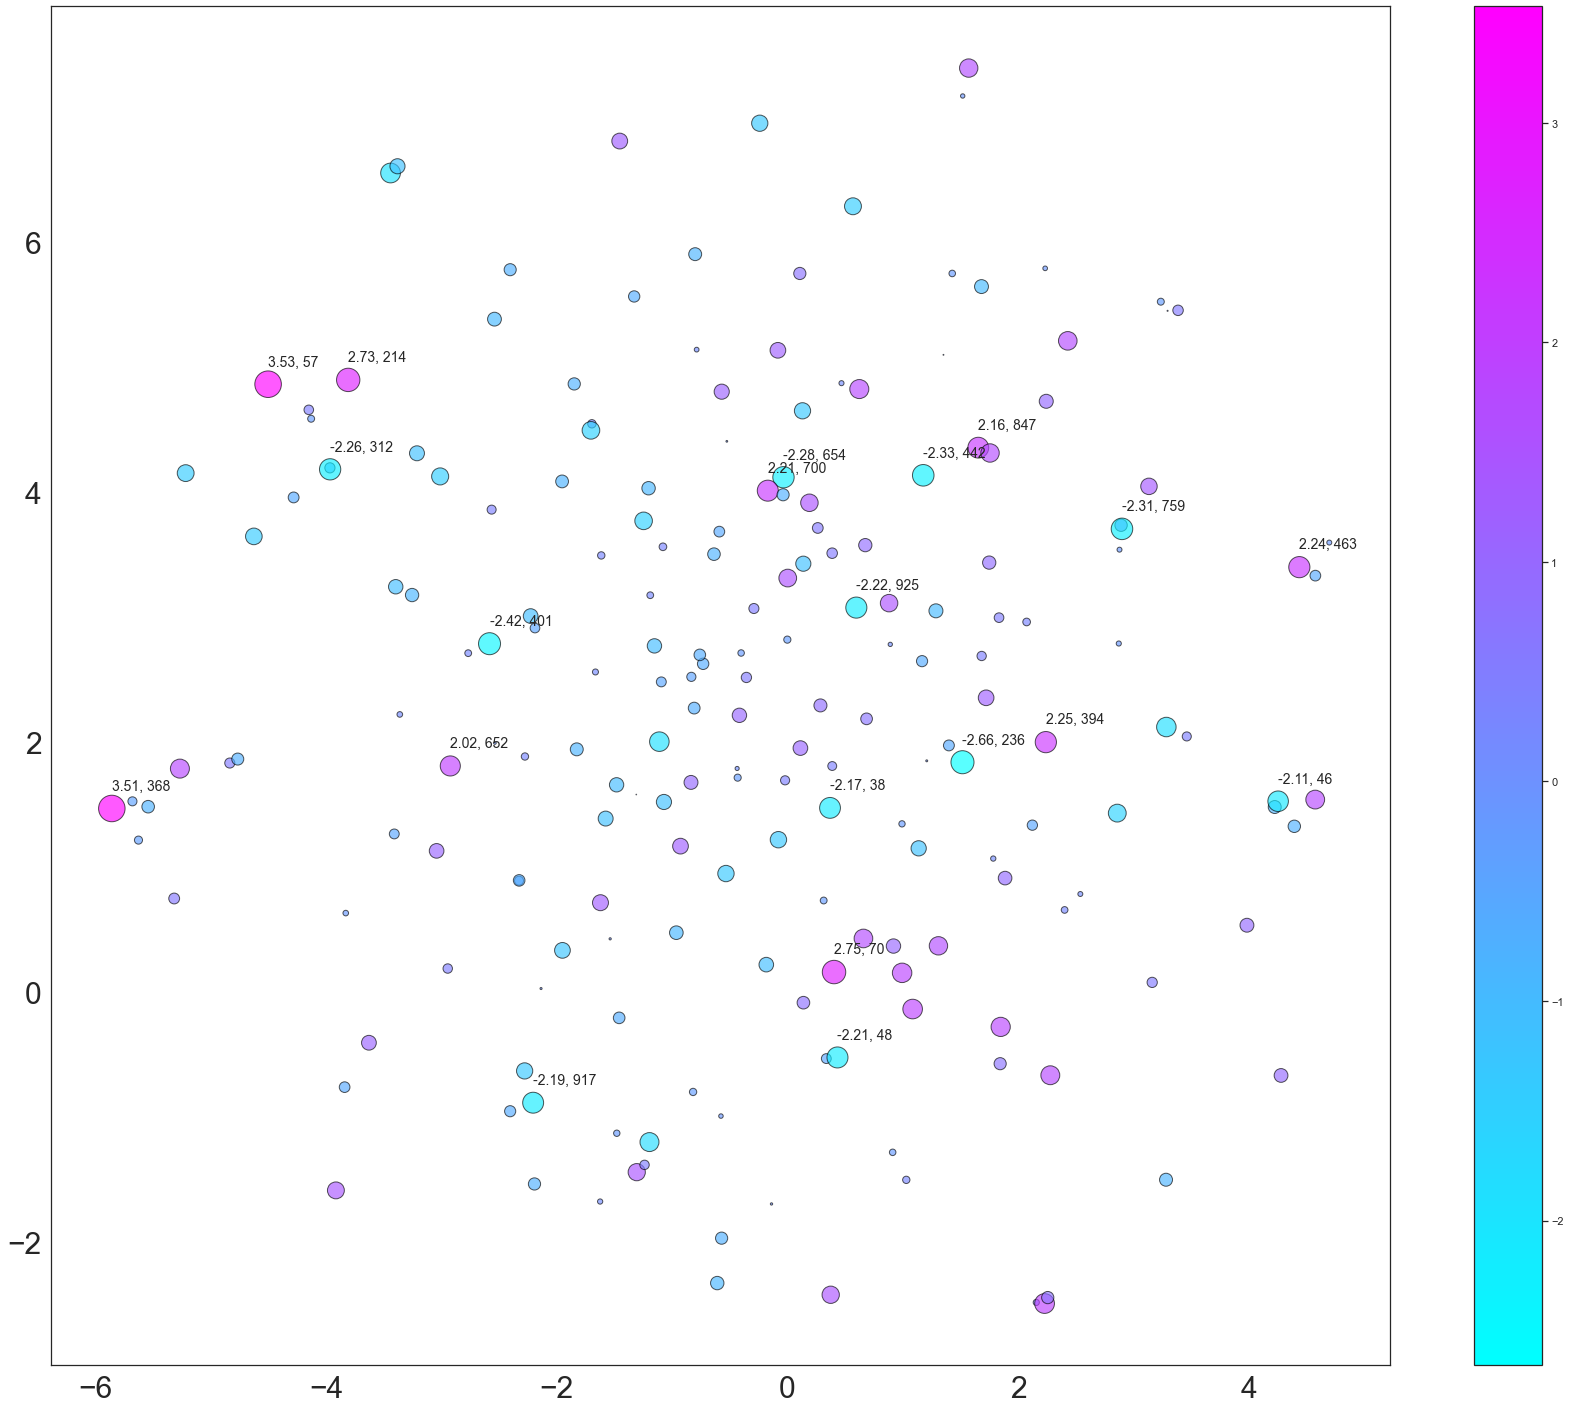

In [203]:
t_sne(x_for_difference_tsne, y_for_difference_tsne, d_difference, 'x', 'y', d_index)

**양수** -> 실제보다 큰 값으로 예측.
**음수** -> 실제보다 작은 값으로 예측.  

절댓값 차이가 2보다 큰 것들에 대해 비교.

양수: 57, 214, 700, 847, 394, 463, 652, 368, 70  
음수: 312, 654, 442, 759, 401, 925, 236, 38, 917, 48, 46  

In [204]:
# 실제보다 큰 값으로 예측한 것들
pos_wrong_list = [57, 214, 700, 847, 394, 463, 652, 368, 70]

# 실제보다 작은 값으로 예측한 것들
neg_wrong_list = [312, 654, 442, 759, 401, 925, 236, 38, 917, 48, 46]

In [193]:
list_sat1 = list(data_df['avg_satisfy_1'])
list_sat2 = list(data_df['avg_satisfy_2'])
list_sat3 = list(data_df['avg_satisfy_3'])
list_sat4 = list(data_df['avg_satisfy_4'])

In [218]:
len_sum = 0

for i in list_index:
    len_sum += len(list_content[int(i)])
    
print(len_sum / len(list_index))

797.975


In [216]:
len_sum = 0

for c in list_content:
    len_sum += len(c)
    
print(len_sum / len(list_content))

793.03


In [220]:
len_sum_pos = 0
for p in pos_wrong_list:
    len_sum_pos += len(list_content[p])
    
print(len_sum_pos / len(pos_wrong_list))    

975.3333333333334


In [221]:
len_sum_neg = 0
for n in neg_wrong_list:
    len_sum_neg += len(list_content[n])
    
print(len_sum_neg / len(neg_wrong_list))    

669.9090909090909


In [207]:
for p in pos_wrong_list:
    print(f'{p} - score1: {list_sat1[p]}, score2: {list_sat2[p]}, score3: {list_sat3[p]}, score4: {list_sat4[p]}\ncontents: {list_content[p]}')
    print(len(list_content[p]))
    print('\n\n\n')

57 - score1: 2.2, score2: 1.8, score3: 3.0, score4: 3.0
contents: Im feeling really down rn... Half empty... A bit angry... Frustrated... Bored... And stressed out... Im in my home town... And it doesnt feel like "home"... Im studying in the capital and i live there by myself but it gets lonely yet i feel less stress... Idk what to do... Ive been scrolling through fb... Chatting with my bf and a friend... But its not helping me at least smile... Its weird how some people mostly strangers can see my fake smiles in pictures... Im only happy when with my partner... But he s not here with me rn, it makes me feel lonely... And i do stupid stuff... Bad stuff... :( im clingy af... Because... Being alone is my phobia... Alone with no on to reach out to... Im not afraid of death... But that Phobia feels worse than death to me... I wanna go back to my home... To my partner... 
Im feeling emotional today...  O...............r............u........o............k.........?............
919




214 - 

In [211]:
for n in neg_wrong_list:
    print(f'{n} - score1: {list_sat1[n]}, score2: {list_sat2[n]}, score3: {list_sat3[n]}, score4: {list_sat4[n]}\ncontents: {list_content[n]}')
    print(len(list_content[n]))
    print('\n\n\n')

312 - score1: 5.6, score2: 5.4, score3: 5.6, score4: 5.2
contents: The majority part of my life i had a lot of friends close and normal one's , i never knew how important they were in my life , untill i lost all of them , Now i am 21 year's old , and i spend all my days alone , sometimes i dont talk to no one for days ,even when i go to the coffe i just keep programming on my computer all the time , i wish if i had someone just to talk with , about anything or just to sit next to me without even talking ... that may sound stupid for most of you guys , but that is my reality ... if someone have any advice i am all ears .... Why donÃ¢ÂÂt you make some friends. I know it sounds obvious but maybe you could talk to someone next time you go to that coffee shop. ItÃ¢ÂÂs never too late to meet new people.
745




654 - score1: 5.2, score2: 6.2, score3: 5.6, score4: 5.8
contents: Or even just running away to start a whole new life but I know I can never bring myself to do either. So, some d

In [212]:
print(len(list_index))

200


In [222]:
list_prediction

[4.252446174621582,
 3.677512645721436,
 3.479670763015747,
 4.307639598846436,
 3.657772064208984,
 4.146743774414063,
 4.718724250793457,
 4.1453166007995605,
 3.6248679161071777,
 4.145415782928467,
 4.69227933883667,
 4.169716358184815,
 4.10063362121582,
 3.734386682510376,
 5.577762126922607,
 3.440880537033081,
 4.211675643920898,
 3.993812799453736,
 4.620521068572998,
 4.653730392456055,
 3.860064268112183,
 3.953261137008667,
 3.101314783096313,
 3.274246454238892,
 4.6420769691467285,
 4.7371697425842285,
 3.5373034477233887,
 3.6797142028808594,
 3.519519090652466,
 3.914175748825073,
 6.030516624450684,
 4.386849403381348,
 2.91264271736145,
 3.761353254318237,
 4.01378345489502,
 6.171026229858398,
 4.232507705688477,
 4.41232967376709,
 5.255461692810059,
 4.518282890319824,
 5.0244975090026855,
 3.7088780403137207,
 4.796796798706055,
 3.3342320919036865,
 3.5275633335113525,
 4.680848121643066,
 4.431227684020996,
 3.6929078102111816,
 4.301995754241943,
 3.99603462219

In [225]:
for i in range(len(list_prediction)):
    print(list_prediction[i], len(list_content[int(list_index[i])]))

4.252446174621582 934
3.677512645721436 1632
3.479670763015747 1237
4.307639598846436 479
3.657772064208984 798
4.146743774414063 420
4.718724250793457 500
4.1453166007995605 856
3.6248679161071777 1139
4.145415782928467 947
4.69227933883667 1386
4.169716358184815 687
4.10063362121582 1053
3.734386682510376 359
5.577762126922607 550
3.440880537033081 842
4.211675643920898 754
3.993812799453736 865
4.620521068572998 635
4.653730392456055 1191
3.860064268112183 683
3.953261137008667 486
3.101314783096313 1157
3.274246454238892 487
4.6420769691467285 659
4.7371697425842285 294
3.5373034477233887 1182
3.6797142028808594 423
3.519519090652466 682
3.914175748825073 1690
6.030516624450684 919
4.386849403381348 829
2.91264271736145 1105
3.761353254318237 609
4.01378345489502 1345
6.171026229858398 894
4.232507705688477 828
4.41232967376709 477
5.255461692810059 1783
4.518282890319824 992
5.0244975090026855 691
3.7088780403137207 664
4.796796798706055 1042
3.3342320919036865 1014
3.527563333511